### 数据预处理

In [6]:
import csv
import pandas as pd
import numpy as np
import json

In [7]:
# data = pd.read_csv('data_new.csv')
# data = pd.read_csv('data_new_category.csv')
data = pd.read_csv('data_all.csv')

In [8]:
target = [["有回应","无回应"], 
        ['积极','中性','消极'], 
        ["专注（任务中）","走神（任务外）"], 
        ["主导", "支持", "旁观", "冲突", "玩乐", "闲聊", "一人独立尝试一人摸鱼", "各自神游"]]

In [9]:
data.head()

,high face 0,high face 1,high face 2,high face 3,high face 4,high face 5,high face 6,high face 7,high face 8,high face 9,...,low pose 210,low pose 211,low pose 212,low pose 213,low pose 214,low pose 215,y1,y2,y3,y4
0,0.359752,0.424275,-0.681706,0.433839,0.004776,0.001909,0.004776,0.001909,97.547158,48.476906,...,2.834029,1.354602,7.016298,13.097574,37.208326,12.016522,0,0,0,2
1,0.374953,0.477638,-0.666732,0.429372,0.010201,0.002640,0.010201,0.002640,94.752225,45.264284,...,2.437439,1.380893,8.850943,1.986816,14.843469,2.682850,0,0,0,2
2,0.374791,0.433773,-0.650851,0.302914,0.027013,0.007587,0.027013,0.007587,103.646422,66.342239,...,264.340206,138.834556,277.803936,40.606839,39.674292,7.152803,0,0,0,0
3,0.425997,0.407457,-0.651442,0.335262,0.018433,0.004401,0.018433,0.004401,107.650662,116.364404,...,1.480924,5.826735,0.277468,0.268455,3.716497,1.082155,0,0,0,0
4,0.283344,0.433831,-0.662919,0.331787,0.020136,0.011439,0.020136,0.011439,97.096686,181.962040,...,2745.552274,351.139817,2397.996836,735.777116,293.425847,120.226725,0,0,0,1


In [10]:
X = data.drop(['y1','y2','y3','y4'],axis=1)
y1 = data['y1']
y2 = data['y2']
y3 = data['y3']
y4 = data['y4']
y = data[['y1','y2','y3','y4']]

In [12]:
if len(idx) != 0:
    print(f"drop {len(idx)} rows with nan value")
    for i in idx:
        X = np.delete(X, i, axis=0)
        y1 = np.delete(y1, i, axis=0)
        y2 = np.delete(y2, i, axis=0)
        y3 = np.delete(y3, i, axis=0)
        y4 = np.delete(y4, i, axis=0)
        y = np.delete(y, i, axis=0)
else:
    X = np.array(X)
    y1 = np.array(y1)
    y2 = np.array(y2)
    y3 = np.array(y3)
    y4 = np.array(y4)
    y = np.array(y)

In [13]:
X_norm = np.apply_along_axis(lambda x: x / np.linalg.norm(x), axis=0, arr=X)


In [14]:
# check nan in X_norm
np.where(np.isnan(X_norm).any(axis=1)==True)

(array([], dtype=int64),)

In [15]:
print(f"Read in videos y:{len(y1)}")

Read in videos y:4289


维度

In [16]:
print(f"X:{len(X[0])}")

X:373


## Train 
注意下面的重复，每次只能跑一个情况

In [17]:
from sklearn.model_selection import train_test_split
# frame split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)
print(f"Video num: X_train:{len(X_train)}, X_test:{len(X_test)}, y_train:{len(y_train)}, y_test:{len(y_test)}")

y1_train, y1_test = y_train[:,0], y_test[:,0]
y2_train, y2_test = y_train[:,1], y_test[:,1]
y3_train, y3_test = y_train[:,2], y_test[:,2]
y4_train, y4_test = y_train[:,3], y_test[:,3]

Video num: X_train:3431, X_test:858, y_train:3431, y_test:858


查看数据分布

有回应:3459, 无回应:830, 


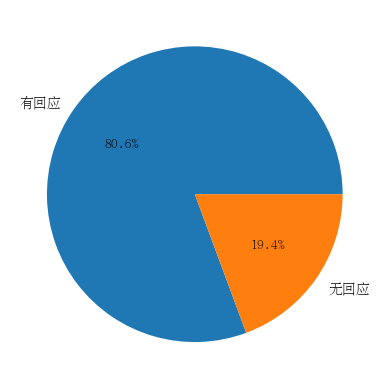

积极:1319, 中性:2408, 消极:562, 


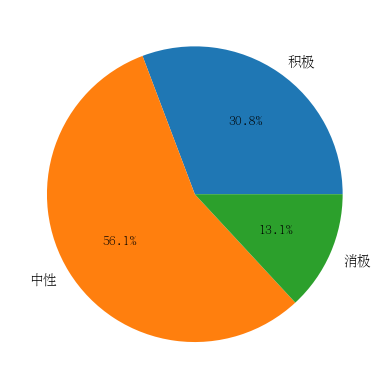

专注（任务中）:3852, 走神（任务外）:437, 


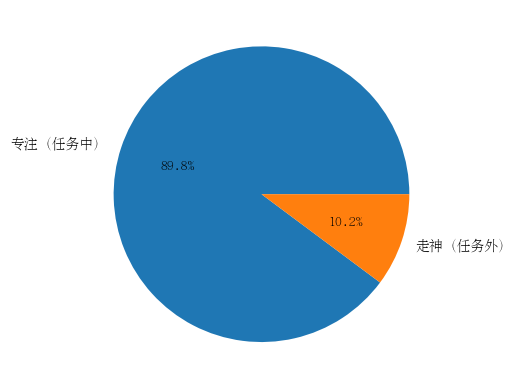

主导:1131, 支持:1439, 旁观:1257, 冲突:25, 玩乐:11, 闲聊:41, 一人独立尝试一人摸鱼:367, 各自神游:18, 


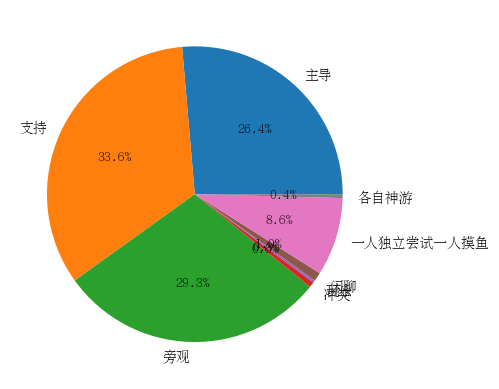

In [18]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties  # 步骤一

plt.rcParams["font.sans-serif"]=["AR PL UMing CN"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

def num_of_cls(y, target): 
    N = []
    for i in range(len(target)):
        print(target[i] + f":{len(y[y==i])}", end=", ")
        N.append(len(y[y==i]))
    print()
    return N

for i in range(4):
    N = num_of_cls(y[:,i],target[i])
    # proportions = [ p/len(y) for p in N]
    plt.pie(N,labels=target[i],autopct='%1.1f%%')
    plt.show()


inversely proportional class weights

In [19]:
from sklearn.utils import class_weight
import numpy as np

# Calculate class weights
class_weights = [class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(i), y=i) for i in [y1,y2,y3,y4]]


# Convert class weights to a dictionary for compatibility with some classifiers
class_weight_dict = [dict(enumerate(class_weights[i])) for i in range(4)]


over_sampling

In [20]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

# RandomOverSampler
X1_resampled, y1_resampled = RandomOverSampler(random_state=42).fit_resample(X_train, y1_train)
X2_resampled, y2_resampled = RandomOverSampler(random_state=42).fit_resample(X_train, y2_train)
X3_resampled, y3_resampled = RandomOverSampler(random_state=42).fit_resample(X_train, y3_train)
X4_resampled, y4_resampled = RandomOverSampler(random_state=42).fit_resample(X_train, y4_train)

# # SMOTE
# X1_resampled, y1_resampled = SMOTE().fit_resample(X_norm, y1)
# X2_resampled, y2_resampled = SMOTE().fit_resample(X_norm, y2)
# X3_resampled, y3_resampled = SMOTE().fit_resample(X_norm, y3)
# X4_resampled, y4_resampled = SMOTE().fit_resample(X_norm, y4)


Cross-validation  
- 5 folds

In [21]:
from sklearn.model_selection import KFold, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV

def crossVal(rfc, X, y):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scoring = ['accuracy', 'f1_weighted', 'recall_weighted', 'precision_weighted']

    # 使用交叉验证器对模型进行评估
    scores = cross_validate(rfc, X, y, cv=kfold, scoring=scoring)

    # 输出交叉验证结果
    print('Accuracy:', scores['test_accuracy'].mean())
    print('F1 score:', scores['test_f1_weighted'].mean())
    print('Recall:', scores['test_recall_weighted'].mean())
    print('Precision:', scores['test_precision_weighted'].mean())

def GridSearch(estimator, param_grid, X_train, y_train, X_test, y_test, target, cv=5):
    # grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv)
    # grid_search = RandomizedSearchCV(estimator=estimator, param_grid=param_grid, cv=cv)
    # grid_search = HalvingGridSearchCV(estimator=estimator, param_distributions=param_grid, cv=cv)
    grid_search = HalvingRandomSearchCV(estimator=estimator,param_distributions=param_grid, cv=cv)


    grid_search.fit(X_train, y_train)

    # print(grid_search.best_params_, grid_search.best_score_)
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best cross-validation score:", grid_search.best_score_)
    
    best_model = grid_search.best_estimator_
    test_score = best_model.score(X_test, y_test)
    y_predict = best_model.predict(X_test)
    print("Test score:", test_score)
    print("Report:")
    report = classification_report(y_test, y_predict, target_names=target, zero_division=0)
    # print(classification_report(y_test, y_predict, target_names=target, zero_division=0))
    confMat = confusion_matrix(y_test, y_predict) # how to upload??
    return best_model, report, grid_search.best_params_

In [22]:
import csv
def parse_report( method, params, report, csv_dir):
    """
    method: [task, classifer, hyperparameters]
    """
    # Parse the classification report
    print(report)
    type(report)
    lines = report.split('\n')
    data = lines[-3:]
    values = [line.split() for line in data]

    # Extract the desired values
    precision = float(values[0][2])
    recall = float(values[0][3])
    f1_score = float(values[0][4])

    # Extract the desired values
    Wprecision = float(values[1][2])
    Wrecall = float(values[1][3])
    Wf1_score = float(values[1][4])

    # Print the extracted values
    print(f"Precision: {precision}, Recall: {recall}, F1-score: {f1_score}, WPrecision: {Wprecision}, WRecall: {Wrecall}, WF1-score: {Wf1_score}")
    with open(csv_dir,'a',newline='') as file:
        writer = csv.writer(file)
        writer.writerow(method)
        writer.writerow(params.keys())
        writer.writerow(params.values())
        writer.writerow([precision,recall,f1_score,Wprecision,Wrecall,Wf1_score])
        writer.writerow([])


### Random Forest

In [23]:

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

# 使用随机森林预测一个frame
rfc = RandomForestClassifier(n_estimators=100, max_depth=10)
rfc.fit(X_train, y_train)
y_predict = rfc.predict(X_test)

for i in range(len(target)):
    print(f"----------------------Task {i}----------------------")
    print(classification_report(y_test[:,i], y_predict[:,i], target_names=target[i],zero_division=0))
    num_of_cls(y_predict[:,i],target[i])


----------------------Task 0----------------------
              precision    recall  f1-score   support

         有回应       0.79      1.00      0.88       673
         无回应       0.50      0.01      0.01       185

    accuracy                           0.78       858
   macro avg       0.64      0.50      0.44       858
weighted avg       0.72      0.78      0.69       858

有回应:856, 无回应:2, 
----------------------Task 1----------------------
              precision    recall  f1-score   support

          积极       0.74      0.20      0.31       250
          中性       0.60      0.97      0.75       490
          消极       0.00      0.00      0.00       118

    accuracy                           0.61       858
   macro avg       0.45      0.39      0.35       858
weighted avg       0.56      0.61      0.52       858

积极:68, 中性:790, 消极:0, 
----------------------Task 2----------------------
              precision    recall  f1-score   support

     专注（任务中）       0.89      1.00      0.94  

In [24]:
csv_dir = "result_all_full.csv"

#### task 1

In [25]:
# GridSearch

rfc = RandomForestClassifier()

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':[class_weight_dict[0]] 
}
RandomForest,report,param = GridSearch(estimator=rfc, 
                            param_grid=param_grid, 
                            X_train=X_train, y_train=y1_train, 
                            X_test=X_test, y_test=y1_test,
                            target=target[0], cv=5)
                            
parse_report(method=["task1","RandomForest"], params = param, report=report, csv_dir=csv_dir)



/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 144 is smaller than n_iter=171. Running 144 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best hyperparameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'class_weight': {0: 0.619976871928303, 1: 2.583734939759036}}
Best cross-validation score: 0.813117761724573
Test score: 0.789044289044289
Report:
              precision    recall  f1-score   support

         有回应       0.79      0.99      0.88       673
         无回应       0.60      0.06      0.12       185

    accuracy                           0.79       858
   macro avg       0.70      0.53      0.50       858
weighted avg       0.75      0.79      0.72       858

Precision: 0.7, Recall: 0.53, F1-score: 0.5, WPrecision: 0.75, WRecall: 0.79, WF1-score: 0.72


#### Task 2

In [26]:
# GridSearch
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':[class_weight_dict[1]] 
}
rfc = RandomForestClassifier()
RandomForest,report,param = GridSearch(estimator=rfc, param_grid=param_grid, 
                            X_train=X_train, y_train=y2_train, 
                            X_test=X_test, y_test=y2_test,
                            target=target[1], cv=5)

parse_report(method=["task2","RandomForest"], params = param, report=report, csv_dir=csv_dir)                            

Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None, 'class_weight': {0: 1.0839019459186252, 1: 0.5937153931339978, 2: 2.543890865954923}}
Best cross-validation score: 0.5931551482754231
Test score: 0.6235431235431236
Report:
              precision    recall  f1-score   support

          积极       0.68      0.31      0.42       250
          中性       0.62      0.93      0.74       490
          消极       0.00      0.00      0.00       118

    accuracy                           0.62       858
   macro avg       0.43      0.41      0.39       858
weighted avg       0.55      0.62      0.55       858

Precision: 0.43, Recall: 0.41, F1-score: 0.39, WPrecision: 0.55, WRecall: 0.62, WF1-score: 0.55


#### Task 3

In [27]:
# GridSearch
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':[class_weight_dict[2]] 
}
rfc = RandomForestClassifier()
RandomForest,report,param = GridSearch(estimator=rfc, param_grid=param_grid, 
                            X_train=X_train, y_train=y3_train, 
                            X_test=X_test, y_test=y3_test,
                            target=target[2], cv=5)
                            
parse_report(method=["task3","RandomForest"], params = param, report=report, csv_dir=csv_dir)  

/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 144 is smaller than n_iter=171. Running 144 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best hyperparameters: {'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'class_weight': {0: 0.556723779854621, 1: 4.907322654462242}}
Best cross-validation score: 0.9016053204907694
Test score: 0.8916083916083916
Report:
              precision    recall  f1-score   support

     专注（任务中）       0.89      1.00      0.94       762
     走神（任务外）       1.00      0.03      0.06        96

    accuracy                           0.89       858
   macro avg       0.95      0.52      0.50       858
weighted avg       0.90      0.89      0.84       858

Precision: 0.95, Recall: 0.52, F1-score: 0.5, WPrecision: 0.9, WRecall: 0.89, WF1-score: 0.84


#### Task 4

In [28]:
# GridSearch
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':[class_weight_dict[3]] 
}
rfc = RandomForestClassifier()
RandomForest,report,param = GridSearch(estimator=rfc, param_grid=param_grid, 
                            X_train=X_train, y_train=y4_train, 
                            X_test=X_test, y_test=y4_test,
                            target=target[3], cv=5)
parse_report(method=["task4","RandomForest"], params = param, report=report, csv_dir=csv_dir)  


Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10, 'class_weight': {0: 0.474027409372237, 1: 0.3725677553856845, 2: 0.4265115354017502, 3: 21.445, 4: 48.73863636363637, 5: 13.076219512195122, 6: 1.4608310626702998, 7: 29.78472222222222}}
Best cross-validation score: 0.43691350863624645
Test score: 0.4289044289044289
Report:
              precision    recall  f1-score   support

          主导       0.37      0.48      0.42       203
          支持       0.52      0.39      0.44       300
          旁观       0.40      0.50      0.45       250
          冲突       0.00      0.00      0.00         8
          玩乐       0.00      0.00      0.00         4
          闲聊       0.00      0.00      0.00         4
  一人独立尝试一人摸鱼       0.51      0.35      0.41        83
        各自神游       0.00      0.00      0.00         6

    accuracy                           0.43       858
   macro avg       0.22      0.21      0.22       858
weighted avg       0.

### DT

In [29]:
from sklearn.tree import DecisionTreeClassifier
# 建立决策树分类器
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
for i in range(len(target)):
    print(f"----------------------Task {i}----------------------")
    print(classification_report(y_test[:,i], y_predict[:,i], target_names=target[i],zero_division=0))
    num_of_cls(y_predict[:,i],target[i])

----------------------Task 0----------------------
              precision    recall  f1-score   support

         有回应       0.79      0.81      0.80       673
         无回应       0.26      0.24      0.25       185

    accuracy                           0.69       858
   macro avg       0.53      0.52      0.52       858
weighted avg       0.68      0.69      0.68       858

有回应:686, 无回应:172, 
----------------------Task 1----------------------
              precision    recall  f1-score   support

          积极       0.40      0.43      0.41       250
          中性       0.60      0.58      0.59       490
          消极       0.17      0.16      0.17       118

    accuracy                           0.48       858
   macro avg       0.39      0.39      0.39       858
weighted avg       0.48      0.48      0.48       858

积极:271, 中性:478, 消极:109, 
----------------------Task 2----------------------
              precision    recall  f1-score   support

     专注（任务中）       0.91      0.90      0

#### task 1

In [30]:
# GridSearch
clf = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':[class_weight_dict[0]] 
}
DT,report,param = GridSearch(estimator=clf, 
                param_grid=param_grid, 
                X_train=X_train, y_train=y1_train, 
                X_test=X_test, y_test=y1_test,
                target=target[0], cv=5)
parse_report(method=["task1","DT"], params = param, report=report, csv_dir=csv_dir)  


Best hyperparameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'criterion': 'entropy', 'class_weight': {0: 0.619976871928303, 1: 2.583734939759036}}
Best cross-validation score: 0.7419313534380614
Test score: 0.7016317016317016
Report:
              precision    recall  f1-score   support

         有回应       0.80      0.83      0.81       673
         无回应       0.27      0.22      0.24       185

    accuracy                           0.70       858
   macro avg       0.53      0.53      0.53       858
weighted avg       0.68      0.70      0.69       858

Precision: 0.53, Recall: 0.53, F1-score: 0.53, WPrecision: 0.68, WRecall: 0.7, WF1-score: 0.69


#### task 2

In [31]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':[class_weight_dict[1]] 
}
clf = DecisionTreeClassifier()
DT,report,param = GridSearch(estimator=clf, 
                param_grid=param_grid, 
                X_train=X_train, y_train=y2_train, 
                X_test=X_test, y_test=y2_test,
                target=target[1], cv=5)

parse_report(method=["task2","DT"], params = param, report=report, csv_dir=csv_dir)  

Best hyperparameters: {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 30, 'criterion': 'gini', 'class_weight': {0: 1.0839019459186252, 1: 0.5937153931339978, 2: 2.543890865954923}}
Best cross-validation score: 0.48020533706673457
Test score: 0.5011655011655012
Report:
              precision    recall  f1-score   support

          积极       0.42      0.42      0.42       250
          中性       0.62      0.61      0.61       490
          消极       0.21      0.22      0.22       118

    accuracy                           0.50       858
   macro avg       0.42      0.42      0.42       858
weighted avg       0.50      0.50      0.50       858

Precision: 0.42, Recall: 0.42, F1-score: 0.42, WPrecision: 0.5, WRecall: 0.5, WF1-score: 0.5


#### task 3

In [32]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':[class_weight_dict[2]] 
}
clf = DecisionTreeClassifier()
DT,report,param = GridSearch(estimator=clf, 
                param_grid=param_grid, 
                X_train=X_train, y_train=y3_train, 
                X_test=X_test, y_test=y3_test,
                target=target[2], cv=5)


parse_report(method=["task3","DT"], params = param, report=report, csv_dir=csv_dir)  

Best hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 15, 'criterion': 'entropy', 'class_weight': {0: 0.556723779854621, 1: 4.907322654462242}}
Best cross-validation score: 0.8595268126743875
Test score: 0.8613053613053613
Report:
              precision    recall  f1-score   support

     专注（任务中）       0.91      0.94      0.92       762
     走神（任务外）       0.35      0.27      0.30        96

    accuracy                           0.86       858
   macro avg       0.63      0.60      0.61       858
weighted avg       0.85      0.86      0.85       858

Precision: 0.63, Recall: 0.6, F1-score: 0.61, WPrecision: 0.85, WRecall: 0.86, WF1-score: 0.85


#### task 4

In [33]:
clf = DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':[class_weight_dict[3]] 
}
DT,report,param = GridSearch(estimator=clf, 
                param_grid=param_grid, 
                X_train=X_train, y_train=y4_train, 
                X_test=X_test, y_test=y4_test,
                target=target[3], cv=5)


parse_report(method=["task4","DT"], params = param, report=report, csv_dir=csv_dir)  


Best hyperparameters: {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 90, 'criterion': 'gini', 'class_weight': {0: 0.474027409372237, 1: 0.3725677553856845, 2: 0.4265115354017502, 3: 21.445, 4: 48.73863636363637, 5: 13.076219512195122, 6: 1.4608310626702998, 7: 29.78472222222222}}
Best cross-validation score: 0.3288551602646731
Test score: 0.2937062937062937
Report:
              precision    recall  f1-score   support

          主导       0.25      0.26      0.25       203
          支持       0.36      0.31      0.33       300
          旁观       0.38      0.35      0.36       250
          冲突       0.00      0.00      0.00         8
          玩乐       0.00      0.00      0.00         4
          闲聊       0.00      0.00      0.00         4
  一人独立尝试一人摸鱼       0.16      0.23      0.19        83
        各自神游       0.00      0.00      0.00         6

    accuracy                           0.29       858
   macro avg       0.14      0.14      0.14       858
weighted avg       0.

### KNN

In [34]:
from sklearn.neighbors import KNeighborsClassifier

# 建立KNN分类器
clf = KNeighborsClassifier(n_neighbors=3)

#### task 1

In [35]:
# GridSearch
clf = KNeighborsClassifier()

param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'leaf_size': list(range(1, 51))
}
KNN,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
                            X_train=X_train, y_train=y1_train, 
                            X_test=X_test, y_test=y1_test,
                            target=target[0], cv=5)
parse_report(method=["task1","KNN"], params = param, report=report, csv_dir=csv_dir)  


/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/base.py", line 668, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 237, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/home/ansonlo/

Best hyperparameters: {'weights': 'uniform', 'p': 1, 'n_neighbors': 15, 'leaf_size': 23}
Best cross-validation score: 0.8186847838550626
Test score: 0.7843822843822844
Report:
              precision    recall  f1-score   support

         有回应       0.79      1.00      0.88       673
         无回应       0.50      0.01      0.02       185

    accuracy                           0.78       858
   macro avg       0.64      0.50      0.45       858
weighted avg       0.72      0.78      0.69       858

Precision: 0.64, Recall: 0.5, F1-score: 0.45, WPrecision: 0.72, WRecall: 0.78, WF1-score: 0.69


#### task 2

In [36]:
# GridSearch
param_grid = {
    'n_neighbors': list(range(1, 29)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'leaf_size': list(range(1, 51))
}
clf = KNeighborsClassifier()
KNN,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
                            X_train=X_train, y_train=y2_train, 
                            X_test=X_test, y_test=y2_test,
                            target=target[1], cv=6)
parse_report(method=["task2","KNN"], params = param, report=report, csv_dir=csv_dir)                             

Best hyperparameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 26, 'leaf_size': 16}
Best cross-validation score: 0.5807828829211036
Test score: 0.6060606060606061
Report:
              precision    recall  f1-score   support

          积极       0.64      0.24      0.35       250
          中性       0.60      0.94      0.73       490
          消极       0.00      0.00      0.00       118

    accuracy                           0.61       858
   macro avg       0.41      0.39      0.36       858
weighted avg       0.53      0.61      0.52       858

Precision: 0.41, Recall: 0.39, F1-score: 0.36, WPrecision: 0.53, WRecall: 0.61, WF1-score: 0.52


#### task 3

In [37]:
param_grid = {
    'n_neighbors': list(range(1, 29)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'leaf_size': list(range(1, 51))
}
clf = KNeighborsClassifier()
KNN,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
                            X_train=X_train, y_train=y3_train, 
                            X_test=X_test, y_test=y3_test,
                            target=target[2], cv=10)

parse_report(method=["task3","KNN"], params = param, report=report, csv_dir=csv_dir)  

Best hyperparameters: {'weights': 'uniform', 'p': 1, 'n_neighbors': 26, 'leaf_size': 31}
Best cross-validation score: 0.9018881626724763
Test score: 0.8881118881118881
Report:
              precision    recall  f1-score   support

     专注（任务中）       0.89      1.00      0.94       762
     走神（任务外）       0.00      0.00      0.00        96

    accuracy                           0.89       858
   macro avg       0.44      0.50      0.47       858
weighted avg       0.79      0.89      0.84       858

Precision: 0.44, Recall: 0.5, F1-score: 0.47, WPrecision: 0.79, WRecall: 0.89, WF1-score: 0.84


#### task 4

In [38]:
param_grid = {
    'n_neighbors': list(range(1, 29)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'leaf_size': list(range(1, 51))
}
clf = KNeighborsClassifier()
KNN,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
                            X_train=X_train, y_train=y4_train, 
                            X_test=X_test, y_test=y4_test,
                            target=target[3], cv=5)
parse_report(method=["task4","KNN"], params = param, report=report, csv_dir=csv_dir)  




Best hyperparameters: {'weights': 'uniform', 'p': 1, 'n_neighbors': 11, 'leaf_size': 11}
Best cross-validation score: 0.37151220245767813
Test score: 0.35664335664335667
Report:
              precision    recall  f1-score   support

          主导       0.30      0.52      0.38       203
          支持       0.45      0.28      0.34       300
          旁观       0.37      0.46      0.41       250
          冲突       0.00      0.00      0.00         8
          玩乐       0.00      0.00      0.00         4
          闲聊       0.00      0.00      0.00         4
  一人独立尝试一人摸鱼       0.33      0.01      0.02        83
        各自神游       0.00      0.00      0.00         6

    accuracy                           0.36       858
   macro avg       0.18      0.16      0.14       858
weighted avg       0.37      0.36      0.33       858

Precision: 0.18, Recall: 0.16, F1-score: 0.14, WPrecision: 0.37, WRecall: 0.36, WF1-score: 0.33


### SVM
结果很差 看warning原因应该是有一些结果直接没有分类  
看看是否需要调参数或者直接去掉 

In [39]:
from sklearn.svm import SVC
clf = SVC()

#### task 1

In [40]:
# GridSearch
clf = SVC()


param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),
    'class_weight':[class_weight_dict[0]]
}
svm,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
                            X_train=X_train, y_train=y1_train, 
                            X_test=X_test, y_test=y1_test,
                            target=target[0], cv=5)

parse_report(method=["task1","SVM"], params = param, report=report, csv_dir=csv_dir)  


Best hyperparameters: {'kernel': 'rbf', 'gamma': 100.0, 'class_weight': {0: 0.619976871928303, 1: 2.583734939759036}, 'C': 10}
Best cross-validation score: 0.8112697320643658
Test score: 0.7832167832167832
Report:
              precision    recall  f1-score   support

         有回应       0.80      0.97      0.88       673
         无回应       0.49      0.09      0.15       185

    accuracy                           0.78       858
   macro avg       0.64      0.53      0.52       858
weighted avg       0.73      0.78      0.72       858

Precision: 0.64, Recall: 0.53, F1-score: 0.52, WPrecision: 0.73, WRecall: 0.78, WF1-score: 0.72


#### task 2

In [41]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),
    'class_weight':[class_weight_dict[1]]
}
clf = SVC()
svm,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
                            X_train=X_train, y_train=y2_train, 
                            X_test=X_test, y_test=y2_test,
                            target=target[1], cv=5)

parse_report(method=["task2","SVM"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'kernel': 'rbf', 'gamma': 1000.0, 'class_weight': {0: 1.0839019459186252, 1: 0.5937153931339978, 2: 2.543890865954923}, 'C': 10}
Best cross-validation score: 0.5585320945229306
Test score: 0.5710955710955711
Report:
              precision    recall  f1-score   support

          积极       0.00      0.00      0.00       250
          中性       0.57      1.00      0.73       490
          消极       0.00      0.00      0.00       118

    accuracy                           0.57       858
   macro avg       0.19      0.33      0.24       858
weighted avg       0.33      0.57      0.42       858

Precision: 0.19, Recall: 0.33, F1-score: 0.24, WPrecision: 0.33, WRecall: 0.57, WF1-score: 0.42


#### task 3

In [42]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),
    'class_weight':[class_weight_dict[2]]
}
clf = SVC()
svm,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
                            X_train=X_train, y_train=y3_train, 
                            X_test=X_test, y_test=y3_test,
                            target=target[2], cv=5)
parse_report(method=["task3","SVM"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'kernel': 'rbf', 'gamma': 100.0, 'class_weight': {0: 0.556723779854621, 1: 4.907322654462242}, 'C': 100}
Best cross-validation score: 0.9040821006765279
Test score: 0.8881118881118881
Report:
              precision    recall  f1-score   support

     专注（任务中）       0.89      1.00      0.94       762
     走神（任务外）       0.50      0.03      0.06        96

    accuracy                           0.89       858
   macro avg       0.70      0.51      0.50       858
weighted avg       0.85      0.89      0.84       858

Precision: 0.7, Recall: 0.51, F1-score: 0.5, WPrecision: 0.85, WRecall: 0.89, WF1-score: 0.84


#### task 4

In [43]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),
    'class_weight':[class_weight_dict[3]]
}
clf = SVC()
svm,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
                            X_train=X_train, y_train=y4_train, 
                            X_test=X_test, y_test=y4_test,
                            target=target[3], cv=5)
parse_report(method=["task4","SVM"], params = param, report=report, csv_dir=csv_dir) 



Best hyperparameters: {'kernel': 'rbf', 'gamma': 1.0, 'class_weight': {0: 0.474027409372237, 1: 0.3725677553856845, 2: 0.4265115354017502, 3: 21.445, 4: 48.73863636363637, 5: 13.076219512195122, 6: 1.4608310626702998, 7: 29.78472222222222}, 'C': 100}
Best cross-validation score: 0.3779926097791527
Test score: 0.3811188811188811
Report:
              precision    recall  f1-score   support

          主导       0.34      0.46      0.39       203
          支持       0.49      0.36      0.42       300
          旁观       0.39      0.38      0.38       250
          冲突       0.00      0.00      0.00         8
          玩乐       0.00      0.00      0.00         4
          闲聊       0.00      0.00      0.00         4
  一人独立尝试一人摸鱼       0.32      0.37      0.35        83
        各自神游       0.00      0.00      0.00         6

    accuracy                           0.38       858
   macro avg       0.19      0.20      0.19       858
weighted avg       0.40      0.38      0.38       858

Precision: 

### XGBoost

In [45]:
from xgboost import XGBClassifier
# 定义xgboost分类器模型
xgb = XGBClassifier(n_estimators=100, random_state=42)

#### task 1

In [46]:
# GridSearch
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb = XGBClassifier(n_estimators=100, random_state=42)
xbgs,report,param = GridSearch(estimator=xgb, param_grid=param_grid, 
                            X_train=X_train, y_train=y1_train, 
                            X_test=X_test, y_test=y1_test,
                            target=target[0], cv=5)
parse_report(method=["task1","XGBoost"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8}
Best cross-validation score: 0.8224095096128119
Test score: 0.7983682983682984
Report:
              precision    recall  f1-score   support

         有回应       0.80      0.99      0.89       673
         无回应       0.75      0.10      0.17       185

    accuracy                           0.80       858
   macro avg       0.77      0.54      0.53       858
weighted avg       0.79      0.80      0.73       858

Precision: 0.77, Recall: 0.54, F1-score: 0.53, WPrecision: 0.79, WRecall: 0.8, WF1-score: 0.73


upsampled!

In [47]:
# GridSearch
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb = XGBClassifier(n_estimators=100, random_state=42)
xbgs,report,param = GridSearch(estimator=xgb, param_grid=param_grid, 
                            X_train=X1_resampled, y_train=y1_resampled, 
                            X_test=X_test, y_test=y1_test,
                            target=target[0], cv=5)
parse_report(method=["task1","upsample XGBoost"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'subsample': 0.7, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best cross-validation score: 0.961502290710438
Test score: 0.7995337995337995
Report:
              precision    recall  f1-score   support

         有回应       0.82      0.96      0.88       673
         无回应       0.60      0.22      0.32       185

    accuracy                           0.80       858
   macro avg       0.71      0.59      0.60       858
weighted avg       0.77      0.80      0.76       858

Precision: 0.71, Recall: 0.59, F1-score: 0.6, WPrecision: 0.77, WRecall: 0.8, WF1-score: 0.76


#### task 2

In [48]:
# GridSearch
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb = XGBClassifier(n_estimators=100, random_state=42)
xbgs,report,param = GridSearch(estimator=xgb, param_grid=param_grid, 
                            X_train=X_train, y_train=y2_train, 
                            X_test=X_test, y_test=y2_test,
                            target=target[1], cv=5)
parse_report(method=["task2","XGBoost"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'subsample': 0.7, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.6}
Best cross-validation score: 0.613777947477833
Test score: 0.6282051282051282
Report:
              precision    recall  f1-score   support

          积极       0.60      0.43      0.50       250
          中性       0.64      0.88      0.74       490
          消极       0.33      0.01      0.02       118

    accuracy                           0.63       858
   macro avg       0.52      0.44      0.42       858
weighted avg       0.59      0.63      0.57       858

Precision: 0.52, Recall: 0.44, F1-score: 0.42, WPrecision: 0.59, WRecall: 0.63, WF1-score: 0.57


Upsample

In [49]:
# GridSearch
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb = XGBClassifier()
xbgs,report,param = GridSearch(estimator=xgb, param_grid=param_grid, 
                            X_train=X2_resampled, y_train=y2_resampled, 
                            X_test=X_test, y_test=y2_test,
                            target=target[1], cv=5)
parse_report(method=["task2","upsample XGBoost"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'subsample': 0.9, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.9}
Best cross-validation score: 0.7175885622162828
Test score: 0.6107226107226107
Report:
              precision    recall  f1-score   support

          积极       0.54      0.50      0.52       250
          中性       0.65      0.79      0.71       490
          消极       0.45      0.11      0.18       118

    accuracy                           0.61       858
   macro avg       0.54      0.47      0.47       858
weighted avg       0.59      0.61      0.58       858

Precision: 0.54, Recall: 0.47, F1-score: 0.47, WPrecision: 0.59, WRecall: 0.61, WF1-score: 0.58


#### task 3

In [50]:
# GridSearch
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb = XGBClassifier(n_estimators=100, random_state=42)
xbgs,report,param = GridSearch(estimator=xgb, param_grid=param_grid, 
                            X_train=X_train, y_train=y3_train, 
                            X_test=X_test, y_test=y3_test,
                            target=target[2], cv=5)
parse_report(method=["task3","XGBoost"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}
Best cross-validation score: 0.922654129878072
Test score: 0.8986013986013986
Report:
              precision    recall  f1-score   support

     专注（任务中）       0.90      0.99      0.95       762
     走神（任务外）       0.71      0.16      0.26        96

    accuracy                           0.90       858
   macro avg       0.81      0.57      0.60       858
weighted avg       0.88      0.90      0.87       858

Precision: 0.81, Recall: 0.57, F1-score: 0.6, WPrecision: 0.88, WRecall: 0.9, WF1-score: 0.87


upsampled

In [51]:
# GridSearch
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb = XGBClassifier()
xbgs,report,param = GridSearch(estimator=xgb, param_grid=param_grid, 
                            X_train=X3_resampled, y_train=y3_resampled, 
                            X_test=X_test, y_test=y3_test,
                            target=target[2], cv=5)
parse_report(method=["task3","upsample XGBoost"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}
Best cross-validation score: 0.987037037037037
Test score: 0.9032634032634033
Report:
              precision    recall  f1-score   support

     专注（任务中）       0.92      0.98      0.95       762
     走神（任务外）       0.65      0.29      0.40        96

    accuracy                           0.90       858
   macro avg       0.78      0.64      0.68       858
weighted avg       0.89      0.90      0.89       858

Precision: 0.78, Recall: 0.64, F1-score: 0.68, WPrecision: 0.89, WRecall: 0.9, WF1-score: 0.89


#### task 4

In [53]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb = XGBClassifier()
xbgs,report,param = GridSearch(estimator=xgb, param_grid=param_grid, 
                            X_train=X_train, y_train=y4_train, 
                            X_test=X_test, y_test=y4_test,
                            target=target[3], cv=5)
parse_report(method=["task4","XGBoost"], params = param, report=report, csv_dir=csv_dir) 

/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=8.
  warnings.warn(
/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
182 fits failed out of a total of 208.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3

Best hyperparameters: {'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.9}
Best cross-validation score: 0.4465144230769231
Test score: 0.48717948717948717
Report:
              precision    recall  f1-score   support

          主导       0.44      0.53      0.48       203
          支持       0.52      0.56      0.54       300
          旁观       0.46      0.46      0.46       250
          冲突       0.00      0.00      0.00         8
          玩乐       0.00      0.00      0.00         4
          闲聊       0.00      0.00      0.00         4
  一人独立尝试一人摸鱼       0.63      0.35      0.45        83
        各自神游       0.00      0.00      0.00         6

    accuracy                           0.49       858
   macro avg       0.26      0.24      0.24       858
weighted avg       0.48      0.49      0.48       858

Precision: 0.26, Recall: 0.24, F1-score: 0.24, WPrecision: 0.48, WRecall: 0.49, WF1-score: 0.48


In [54]:
# GridSearch
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb = XGBClassifier()
xbgs,report,param = GridSearch(estimator=xgb, param_grid=param_grid, 
                            X_train=X4_resampled, y_train=y4_resampled, 
                            X_test=X_test, y_test=y4_test,
                            target=target[3], cv=5)
parse_report(method=["task4","upsample XGBoost"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.8}
Best cross-validation score: 0.8275471900471901
Test score: 0.49067599067599066
Report:
              precision    recall  f1-score   support

          主导       0.45      0.55      0.49       203
          支持       0.53      0.58      0.55       300
          旁观       0.46      0.41      0.43       250
          冲突       0.00      0.00      0.00         8
          玩乐       0.00      0.00      0.00         4
          闲聊       0.00      0.00      0.00         4
  一人独立尝试一人摸鱼       0.60      0.40      0.48        83
        各自神游       0.00      0.00      0.00         6

    accuracy                           0.49       858
   macro avg       0.25      0.24      0.24       858
weighted avg       0.48      0.49      0.48       858

Precision: 0.25, Recall: 0.24, F1-score: 0.24, WPrecision: 0.48, WRecall: 0.49, WF1-score: 0.48


### LSTM  
not working so far

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb = XGBClassifier()
GridSearch(estimator=xgb, param_grid=param_grid, 
                            X_train=X_train, y_train=y4_train, 
                            X_test=X_test, y_test=y4_test,
                            target=target[3], cv=8)

/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
154 fits failed out of a total of 176.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
22 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/xgboost/sklearn.py", line 1440, in fit
    raise ValueError(


In [77]:
from torch import nn
import torch

class LSTM(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(100, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 4) # 4 classes
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.lstm(x) # 1 * 100
        out = self.fc1(out[:, -1, :])
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out
        
class mil_regression(nn.Module):
    def __init__(self, input_size=786, hidden_size=100, num_layers=1, output_size=1):
        ''' use LSTM for MIL '''
        super(mil_regression, self).__init__()
        self.net = LSTM(input_size, hidden_size, num_layers)
        self.class_num = output_size

    def forward(self, inputs):
        # input shape: (frame_num, feature_size)
        

        self.seg_num, self.feature_num = inputs.shape #

        # outputs = torch.zeros((self.seg_num, self.class_num)).double.cuda() #  frame * 4（bool）

        outputs = self.net(inputs)
        # for i in range(self.seg_num):
        #     outputs[i,:] = self.net(inputs[i]) # 786

        # for idx, seg in enumerate(inputs):
        #     seg = Variable(seg).cuda()
        #     outputs[idx] = self.net(seg)

        # 视频特征 = frame取平均
        output = torch.mean(outputs, 1).cuda()
        return output

In [ ]:
import torch 

model = mil_regression().cuda()

epochs = 150
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
    for i in range(len(X_train)): # 每次处理一个视频(对batch)

        x = torch.tensor(X_train[i]).float().cuda()
        y = torch.tensor(y_train[i]).float().cuda()
        

        if len(x.shape) ==1:
            continue

        optimizer.zero_grad()
        
        y_pred = model(x)

        single_loss = loss_function(y_pred, y)
        single_loss.backward()
        optimizer.step()
        
        # if (i+1) % 10 == 0:
        #     print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, len(X_train), single_loss.item()))

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

In [ ]:
with torch.no_grad():
    
    correct = 0
    total = 0
    for i in range(len(X_test)): # 每次处理一个视频(对batch)
        x = torch.tensor(X_test[i]).float().cuda()
        y = torch.tensor(y_test[i]).float().cuda()
        print(y)

        if len(x.shape) ==1:
            continue

        outputs = model(x)
        print(outputs)
        correct += (outputs == y)

### testing

In [10]:
import numpy as np

# 创建一个二维矩阵
x = np.array([[1, 2, 3], [4, 5, 6], [5, 8, 100],[5, 8, 100]])

# 计算梯度
dy = np.gradient(x)

# 输出结果
print(dy)


[array([[ 3. ,  3. ,  3. ],
       [ 2. ,  3. , 48.5],
       [ 0.5,  1.5, 47. ],
       [ 0. ,  0. ,  0. ]]), array([[ 1. ,  1. ,  1. ],
       [ 1. ,  1. ,  1. ],
       [ 3. , 47.5, 92. ],
       [ 3. , 47.5, 92. ]])]


In [9]:
import numpy as np

# 创建一个二维数组
x = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# 计算每一行相邻行之间的二阶导数
d2x = []
for i in range(1, x.shape[0]-1):
    dx1 = np.gradient(x[i-1, :])
    dx2 = np.gradient(x[i, :])
    dx3 = np.gradient(x[i+1, :])
    d2x.append(np.diff(dx2-dx1) / np.diff(dx3-dx2))

# 输出结果
print(d2x)


[array([nan, nan])]


/tmp/ipykernel_162420/1742590338.py:12: RuntimeWarning: invalid value encountered in divide
  d2x.append(np.diff(dx2-dx1) / np.diff(dx3-dx2))


In [11]:
import numpy as np

# 创建一个二维数组
x = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# 计算每一行数据对上一行数据的导数
dx = []
for i in range(1, x.shape[0]):
    diff = np.diff(x[i, :]) / np.diff(x[i-1, :])
    dx.append(diff)

# 输出结果
print(dx)


[array([1., 1.]), array([1., 1.])]


In [37]:
import pandas as pd

# 假设df是一个DataFrame对象，其中包含frame和feature两列
df = pd.DataFrame({'frame': [1, 3], 'feature': [1, 5]})

# 将df的索引设置为frame列，并增加需要插值的索引值
df = df.set_index('frame').reindex(range(df['frame'].min(), df['frame'].max()+1))

# 对df进行插值
df_interpolated = df.interpolate().reset_index()

# 输出插值结果
print(df_interpolated)


   frame  feature
0      1      1.0
1      2      3.0
2      3      5.0
